In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 10 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
a_r = 1.5
b_r = -0.4
total_weeks = 10
stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params)
    simulation_this_week.b_r = b_r
    simulation_this_week.a_r = a_r
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/10_weeks_a_r1.5_b_r-0.4/demand_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/10_weeks_a_r1.5_b_r-0.4/supply_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [6]:
weekly_sim_log_df = pd.read_json("../data/10_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_0_.log", lines=True)

In [7]:
weekly_sim_log_df.shape

(1069, 12)

In [8]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

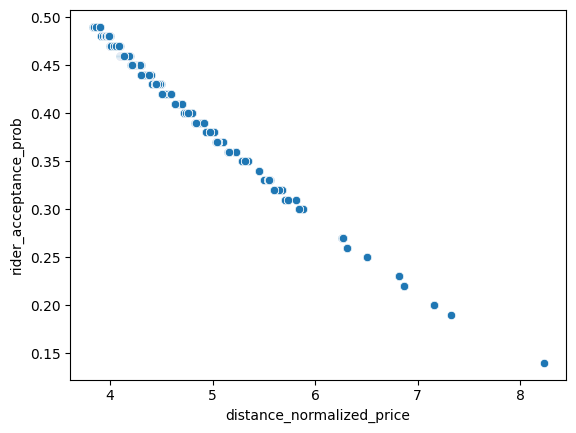

In [9]:
weekly_sim_log_df = pd.read_json("../data/10_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_"+str(0)+"_.log", lines=True)
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [10]:
# ### all the 10 weeks has a similar plot for rider's short-term elasticity
# for i in range(10):
#     weekly_sim_log_df = pd.read_json("../data/10_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_"+str(i)+"_.log", lines=True)
#     sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
#     plt.show()

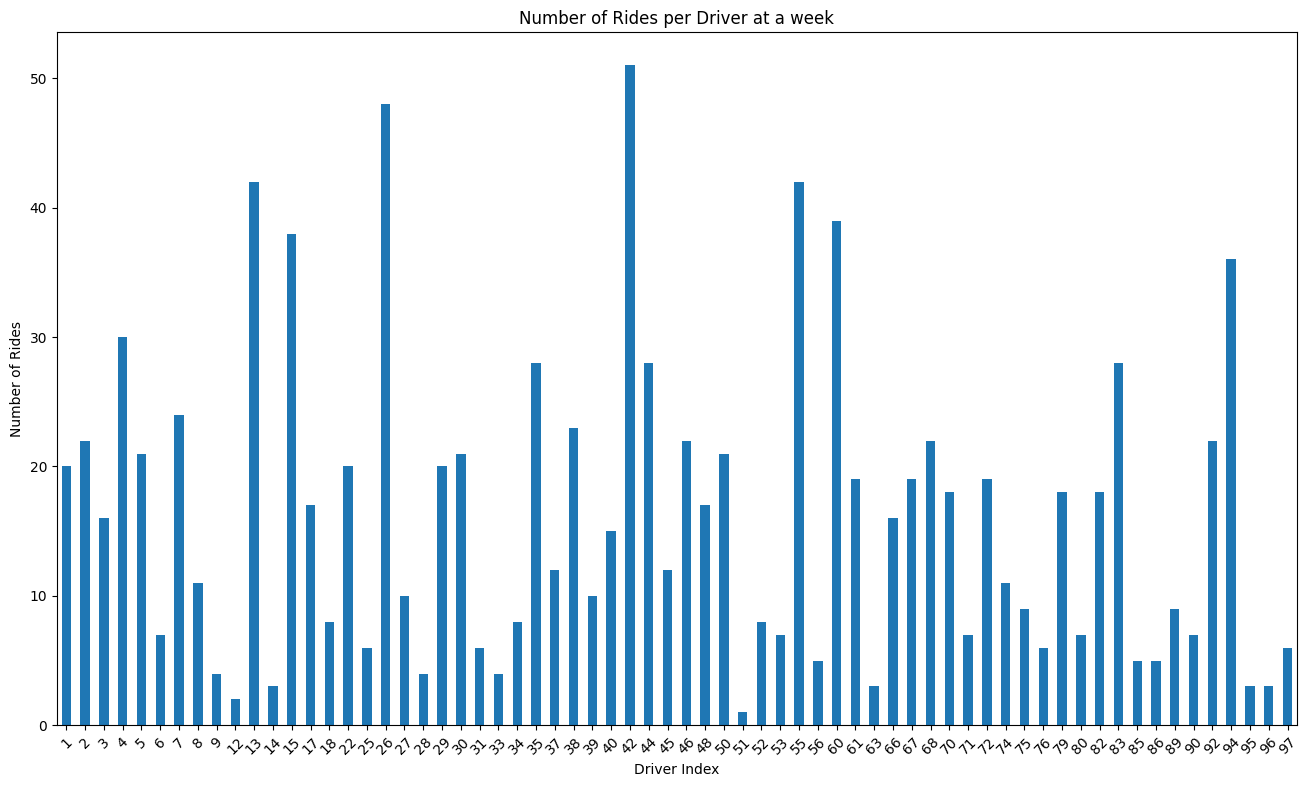

In [11]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 16.19 rides per week

In [12]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

16.196969696969695

In [13]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.478989710009355, 0.4292048643592143)

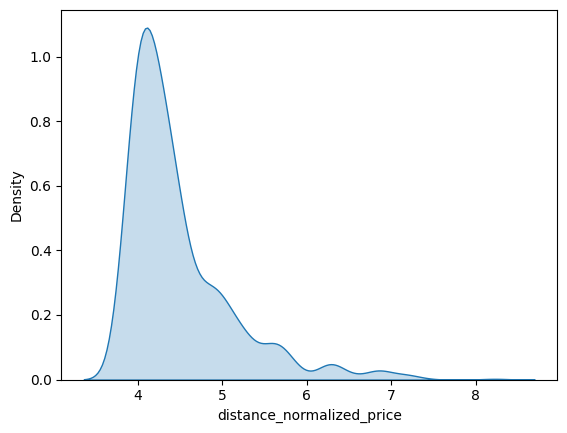

In [14]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

In [15]:
# # ### all the 10 weeks has a similar plot for rider's distance_normalized_price density
# for i in range(10):
#     weekly_sim_log_df = pd.read_json("../data/10_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_"+str(i)+"_.log", lines=True)
#     sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
#     plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

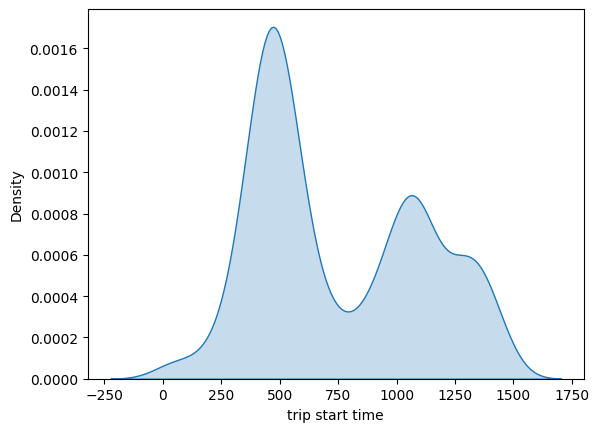

In [16]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

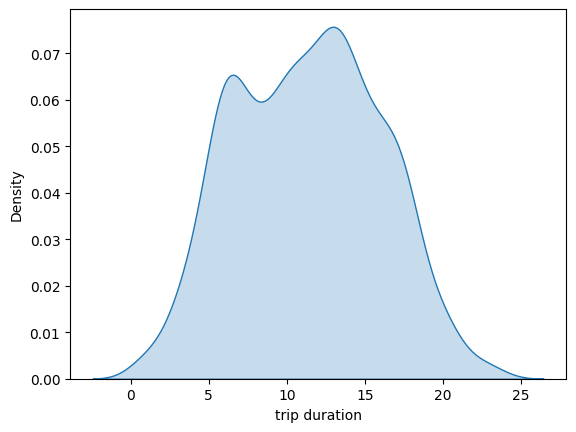

In [17]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

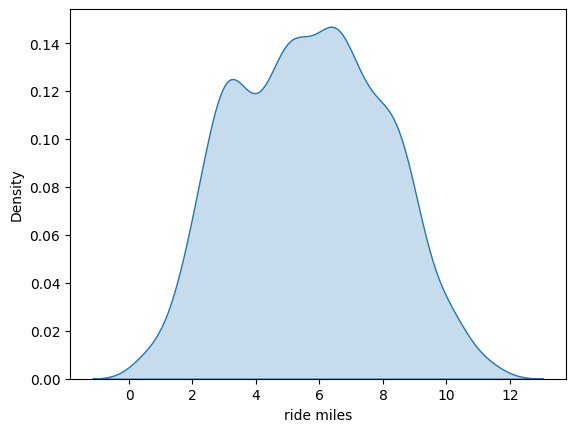

In [18]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

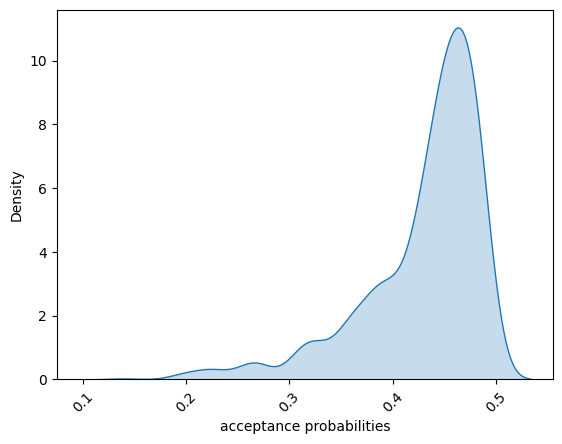

In [19]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

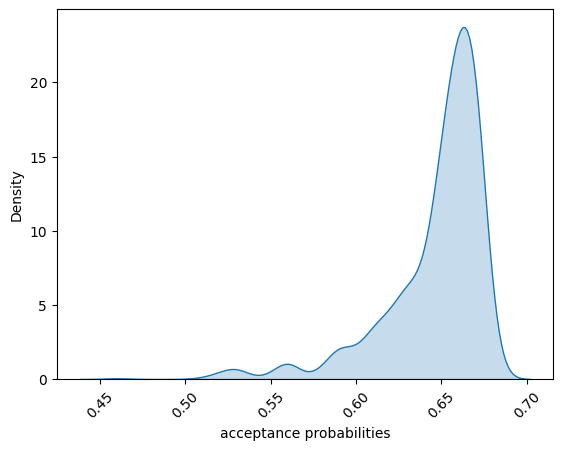

In [20]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [21]:
daily_avg_price_lst, daily_total_requests = [], []
for i in range(10):
    trips_df = pd.read_json('../data/10_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_'+str(i)+'_.log', lines=True)
    requests_df = pd.read_json('../data/10_weeks_a_r1.5_b_r-0.4/demand_week_'+str(i)+'.json')
    daily_avg_price_lst.append(trips_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [22]:
daily_avg_price_lst, daily_total_requests

([24.151608980355473,
  25.883565965583173,
  24.4051568627451,
  24.63511562718991,
  23.979908713692947,
  24.368110026619345,
  23.540607734806628,
  24.65881010594947,
  24.419386189258315,
  25.330309698451508],
 [939, 957, 902, 992, 925, 1035, 1084, 1007, 991, 1021])

In [23]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [24]:
long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [25]:
long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [26]:
long_term_rider_elasticity_df

,daily_avg_price,daily_total_requests,daily_avg_price_change,daily_total_requests_change
0,24.151609,939,NaN,NaN
1,25.883566,957,0.071712,0.019169
2,24.405157,902,-0.057118,-0.057471
3,24.635116,992,0.009423,0.099778
4,23.979909,925,-0.026596,-0.067540
5,24.368110,1035,0.016189,0.118919
6,23.540608,1084,-0.033958,0.047343
7,24.658810,1007,0.047501,-0.071033
8,24.419386,991,-0.009709,-0.015889
9,25.330310,1021,0.037303,0.030272


In [27]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(24.537257990465186, 985.3)

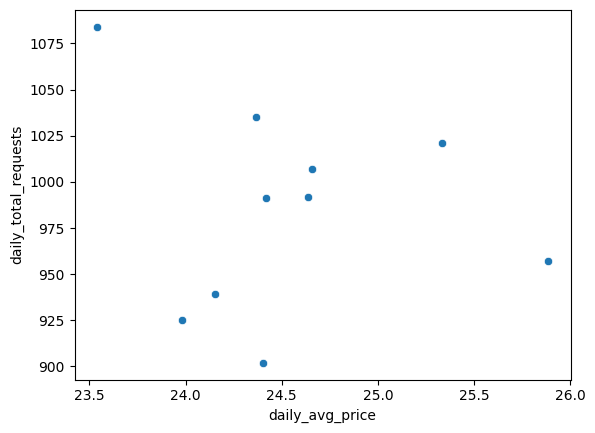

In [28]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.show()

In [29]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-12.938533921195058,
 1302.7761448427482,
 -0.15547097875239252,
 0.6680091598022855,
 29.065483565002165)

### roughly 4.3%(i.e. 1 / 23) increase of ride price will cause a decrease of 1.2%(i.e. 28/1015) for the next day's requests

### as below, the ride share company makes $7.25 per ride

In [30]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(24.15, 25818.07)

In [31]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

7.25